#One Time Run

In [1]:
import pandas as pd
import numpy as np
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
#loading data
data_raw = pd.read_excel('DATA-SVR.xlsx')
data_raw = data_raw.dropna(axis=1, how='all')

In [3]:
# Parameter SVR 
lamda   = 0.01
epsilon = 0.000001
cLR     = 0.0001
C       = 0.1
d       = 3
sigma   = 0.9

In [4]:
X = data_raw.iloc[:,2:8]
Y = data_raw['Selisih']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, shuffle=False)

In [5]:
data_raw

,Tanggal,Selisih,Crude Oil,S&P 500 Index,Exchange Rate,Dollar Index,Federal Fund Rate,Consumer Price Index
0,2019-11-01,5308126.74,56.040000,3066.910000,14123.500000,97.239998,1.570000,12.507399
1,2019-11-04,5316822.93,56.330000,3078.270000,14014.000000,97.510002,1.560000,12.507399
2,2019-11-05,5708093.56,57.040000,3074.620000,14058.000000,97.980003,1.560000,12.507399
3,2019-11-06,5652608.99,56.150000,3076.780000,14028.500000,97.949997,1.550000,12.507399
4,2019-11-07,5695972.37,56.910000,3085.180000,14008.000000,98.139999,1.550000,12.507399
...,...,...,...,...,...,...,...,...
300,2020-12-25,343404.00,51.051261,2684.793145,14148.643555,96.051226,1.149769,12.507399
301,2020-12-28,445217.00,47.500000,3735.360000,13911.143555,90.339996,0.090000,12.507399
302,2020-12-29,531533.31,47.850000,3727.040000,14126.120117,90.010002,0.090000,12.507399
303,2020-12-30,451624.63,48.240000,3732.040000,14069.909180,89.629997,0.090000,12.507399


In [6]:
def normalisasi(data):
    scaler = MinMaxScaler()
    scaler.fit(data)
    return scaler.transform(data), scaler

X_train_scaled, XTrain_scaler = normalisasi(X_train)
y_train_scaled, YTrain_scaler = normalisasi(y_train.values.reshape(-1,1))
X_test_scaled = XTrain_scaler.transform(X_test)

In [7]:
def menghitungJarakTrain(calculate):
    # asumsi dataframe calculate dah bener
    baris = calculate.shape[0]
    kolom = calculate.shape[1]
    hasil = np.zeros((baris,baris))
    
    # calculate = data.iloc[:,1:8].copy()
    # df1 = calculate.pop('Selisih')
    # calculate['Selisih'] = df1
    calculate = calculate.to_numpy()
    
    for i in range(baris):
        for j in range(baris):
            hasil1 = 0
            for k in range(kolom-1):
                temp = math.pow(calculate[i][k] - calculate[j][k], 2)
                hasil1 += temp
            hasil[i][j] = hasil1
    
    return hasil

y_train_df = pd.DataFrame(y_train_scaled, columns=['Selisih'])
X_train_df = pd.DataFrame(X_train_scaled)
data_new = pd.concat([X_train_df, y_train_df], axis = 1)

matriksJarakTrain = menghitungJarakTrain(data_new)

In [8]:
def matrixHessian(matriksJarak, lamda, sigma):
    baris = matriksJarak.shape[0]
    kolom = matriksJarak.shape[1]
    matrix3 = np.zeros((baris,kolom))
    for i in range(baris):
        for j in range(kolom):
            # Rumus Sesuai Fungsi Kernel RBF (Pers 3.12)
            matrix3[i][j] = math.exp(-1 * matriksJarak[i][j] / (2 * (sigma**2))) + lamda**2
    return matrix3

hessian = matrixHessian(matriksJarakTrain, lamda, sigma)

print("Hessian train shape", hessian.shape)

Hessian train shape (228, 228)


In [9]:
# Sequential Learning
# Goal : Nilai a* dan a
def sequentialLearning(data_train, datay_train, matrix_hessian, epsilon, C, cLR, maxIter = 100):
    z = 1
    
    a_star_init = list(np.zeros(data_train.shape[0]))
    a_init = list(np.zeros(data_train.shape[0]))

    hasilDalfaS = list(np.zeros(data_train.shape[0]))
    hasilDalfa = list(np.zeros(data_train.shape[0]))

    UpdateAlfaS = list(np.zeros(data_train.shape[0]))
    UpdateAlfa = list(np.zeros(data_train.shape[0]))

    baris = matrix_hessian.shape[0]
    kolom = matrix_hessian.shape[1]

    while z < maxIter:
        
        #Menghitung Nilai Error
        nilaiE = np.zeros(baris)
        for i in range(baris):
            total_error = 0
            for j in range(kolom):
                error = (a_star_init[j] - a_init[j]) * matrix_hessian[i][j]
                total_error += error
            nilaiE[i] = datay_train[i] - total_error

        #Menghitung Nilai Delta a* Delta a
        maxR = max(matrix_hessian.diagonal())
        gamma = cLR/maxR
        
        for i in range(baris):
            hasilDalfaS[i] = min(max(gamma*(nilaiE[i]-epsilon), -a_star_init[i]), C - a_star_init[i])
            hasilDalfa[i] = min(max(gamma*(-nilaiE[i]-epsilon), -a_init[i]), C - a_init[i])

        #Menghitung Nilai a* dan a
        for i in range(baris):
            UpdateAlfaS[i] = a_star_init[i] + hasilDalfaS[i]
            UpdateAlfa[i] = a_init[i] + hasilDalfa[i]
        
        a_star_init = UpdateAlfaS
        a_init = UpdateAlfa
        z+=1
        
        #Do Something with Trigger
        if max(abs(np.asarray(hasilDalfaS))) < epsilon and max(abs(np.asarray(hasilDalfa))) < epsilon:
            break

    return a_star_init, a_init

a_bintang, a_biasa = sequentialLearning(X_train_scaled, y_train_scaled, hessian, epsilon, C, cLR)
print("ini a bintang length\n", len(a_bintang))
print("ini a biasa length\n", len(a_biasa))

ini a bintang length
 228
ini a biasa length
 228


In [10]:
def menghitungJarakTest(data_train, data_test):
    # asumsi dataframe calculate dah bener
    
    baris = data_test.shape[0]
    kolom = data_train.shape[0]
    hasil = np.zeros((baris,kolom))
    
    # data_train = data_train.to_numpy()
    # data_test = data_test.to_numpy()
    
    for i in range(baris):
        for j in range(kolom):
            hasil1 = 0
            for k in range(data_train.shape[1]-1):
                temp = math.pow(data_test[i][k] - data_train[j][k], 2)
                hasil1 += temp
            hasil[i][j] = hasil1
    
    return hasil
matriksJarak_test = menghitungJarakTest(X_train_scaled, X_test_scaled)

In [11]:
hessian_test = matrixHessian(matriksJarak_test, lamda, sigma)

print("Hessian test shape", hessian_test.shape)

Hessian test shape (77, 228)


In [12]:
#Hitung hasil regresi
def fungsiRegresi(data, matrix_hessian, a_star, a):
    # print(matrix_hessian)
    baris = data.shape[0]
    sum_fx = list()
    
    for i in range(baris):
        sum_fx.append(sum([(a_star[j] - a[j])*matrix_hessian[i][j] for j in range(baris)]))
    # print(sum_fx)
    return sum_fx

result = fungsiRegresi(X_test_scaled, hessian_test, a_bintang, a_biasa)
result_inverted = YTrain_scaler.inverse_transform(np.array(result).reshape(-1,1))

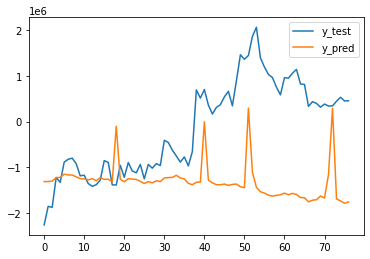

mape = 1.99 %


In [13]:
mape = mean_absolute_percentage_error(y_test,result_inverted)
#Plotting
def plot(y_test, y_pred):
    # y_test = y_test.reset_index()
    # y_pred = y_pre
    plt.plot(np.arange(len(y_test)),y_test)
    plt.plot(np.arange(len(y_pred)),y_pred)
    plt.legend(['y_test','y_pred'])
    plt.show()
plot(y_test,result_inverted)
print("mape = %.2f" % (mape),"%")

In [14]:
#loading data prediksi baru
data_baru = pd.read_excel('PREDIKSI-BARU.xlsx')
data_baru = data_baru.tail(77)

In [15]:
data_baru['Prediksi Selisih'] = result_inverted
data_baru['Prediksi Baru'] = data_baru['Prediksi Selisih']+data_baru['Data Aktual']

new_mape = mean_absolute_percentage_error(data_baru['Data Aktual'], data_baru['Prediksi Baru'])
print("mape = %.2f" % (new_mape),"%")

mape = 0.05 %


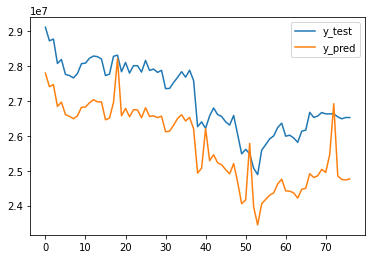

In [16]:
plot(data_baru['Data Aktual'], data_baru['Prediksi Baru'])

In [22]:
#predict new data

# Parameter SVR 
lamda   = 0.01
epsilon = 0.000001
cLR     = 0.0001
C       = 0.1
d       = 3
sigma   = 0.9


X_test_new = pd.read_excel('Xtrain-New.xlsx')
X_test_new = X_test_new.iloc[:,2:8]
X_test_new_scaled  = XTrain_scaler.transform(X_test_new)

In [23]:
matriksJarak_test_new = menghitungJarakTest(X_train_scaled, X_test_new_scaled)
hessian_new = matrixHessian(matriksJarak_test_new, lamda, sigma)
hasil_new = fungsiRegresi(X_test_new_scaled, hessian_new, a_bintang, a_biasa)
hasil_new_unscaled = YTrain_scaler.inverse_transform(np.array(hasil_new).reshape(-1,1))

In [24]:
pd.DataFrame(hasil_new_unscaled)

,0
0,-3.259419e+06
1,-3.264091e+06
2,-3.264189e+06
3,-3.264188e+06
4,-3.263018e+06
